# Predicting cloud cover using Linear regression

In [1]:
import numpy as np
import scipy.sparse as sp
np.random.seed(12)

import warnings
#Comment this to turn on warnings
warnings.filterwarnings('ignore')

from model_comparison import model_comparison
from resample import resample
import algorithms
import matplotlib.pyplot as plt
import seaborn as sns
import netCDF4 as n
from sklearn.linear_model import LinearRegression

from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

from utils import train_test_split
from utils import mean_squared_error, r2_score, A_R2, NRMSE
#%matplotlib notebook

from sklearn.preprocessing import StandardScaler

In [2]:
def logit_inv(x): 
    return np.exp(x)/(1 + np.exp(x))

def logit(x):
    return np.log(x+1e-12) - np.log(1+1e-12-x)

def standardicing_responce(y):
    return (y-np.mean(y))/np.std(y)

# Reading in the data

In [3]:
# reading test
path = "./files/"
filenames = ["specific_humidity_Europa_sp.nc", "relative_humidity_Europa_sp.nc", "pressure_Europa_sp.nc",  
             "temperature_Europa_sp.nc", "total_cloud_cover_Europa_sp.nc"]


cloud = n.Dataset(path + filenames[-1], "r")
relative = n.Dataset(path + filenames[1], "r")
specific = n.Dataset(path + filenames[0], "r")
pressure = n.Dataset(path + filenames[2], "r")
temperature = n.Dataset(path + filenames[3], "r")

In [4]:
tcc = cloud.variables["tcc"][:][:][:].data
rel = relative.variables["r"][:][:][:][:].data
spe = specific.variables["q"][:][:][:][:].data
surf_pre = pressure.variables["sp"][:][:][:].data
temp = temperature.variables["t2m"][:][:][:].data

In [5]:
rel.shape

(32, 6, 61, 77)

In [6]:
temp.shape

(32, 61, 77)

In [7]:
# Choosing the number of days for training and testing.

In [8]:
# for one certain timestep 

n_days = 7

TCC = []
REL = []
SPE = []
PRE = []
TEMP = []


for t in range(n_days*4):
    TCC.append(tcc[t][:][:].flatten())
    #print(rel[t][0].flatten().shape)
    REL.append(rel[t][0][:][:].flatten())
    SPE.append(spe[t][0][:][:].flatten())
    PRE.append(surf_pre[t][:][:].flatten())
    TEMP.append(temp[t][:][:].flatten())


In [9]:
y =(np.array(TCC).flatten())
temp = y[y<1]
#y[y>1] = temp.max()
#X = np.array([np.array(REL).flatten(), np.array(SPE).flatten(), np.array(PRE).flatten(), np.array(TEMP).flatten()])
#y = logit(np.array(TCC).flatten())

In [10]:
# Need to determine the largest number smaller than zero to swap all elements larger than one with this...
temp.max()

0.9999694810258271

In [11]:
y[y>1] = temp.max()

In [12]:
X = np.array([np.array(REL).flatten(), np.array(SPE).flatten(), np.array(PRE).flatten(), np.array(TEMP).flatten()])
y = logit(np.array(TCC).flatten())

In [13]:
y.shape

(131516,)

In [14]:
X[0].shape, X[1].shape ,X[2].shape, X[3].shape

((131516,), (131516,), (131516,), (131516,))

In [15]:
X = X.transpose()

In [16]:
X.shape

(131516, 4)

In [17]:
y.max(), y.min()

(36.04365338911915, -26.93794050959591)


# Regression analysis combined with applying a logit transformation.

In [18]:
# Experimental setup
models = {
    "ols": algorithms.OLS,
    'ridge': algorithms.Ridge, 
    "lasso": algorithms.Lasso
}

param_grid = {
    'ols': [0],
    'ridge': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100, 10**3, 10**4, 10**5],  
    'lasso': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100, 10**3, 10**4, 10**5]
}

# Choosing the same splitsize as the notebook in order to compare. 
results, z_pred_best, coeffs = model_comparison(
    models, param_grid, X, y, split_size=0.2
    )

Testing model: ols
Testing model: ridge
Testing model: lasso
3


In [19]:
coeffs["lasso"]

[[array([ 4.85073754e-01, -1.51289351e+03,  3.37945485e-05,  1.58784822e-01]),
  array([ 2.52695537e-02, -0.00000000e+00,  5.18901567e-06, -1.64605972e-02]),
  array([ 2.52596902e-02, -0.00000000e+00,  5.13094521e-06, -1.63027268e-02]),
  array([ 2.51610469e-02, -0.00000000e+00,  4.55025496e-06, -1.47240307e-02]),
  array([ 2.39632608e-02, -0.00000000e+00, -7.75459134e-07, -0.00000000e+00]),
  array([ 0.00000000e+00, -0.00000000e+00, -5.37882581e-06, -0.00000000e+00]),
  array([ 0., -0., -0., -0.]),
  array([ 0., -0., -0., -0.]),
  array([ 0., -0., -0., -0.]),
  array([ 0., -0., -0., -0.])]]

In [20]:
results["mse_test"]["lasso"]

[[1.356894699161184,
  1.1982962216724502,
  1.1980849304974917,
  1.1963624498073027,
  1.2355636268247245,
  2.0943925421439786,
  nan,
  nan,
  nan,
  nan]]

In [21]:
results.keys()

dict_keys(['mse_test', 'mse_train', 'r2_test', 'r2_train'])

In [22]:
results["r2_test"]["ridge"]

[[-0.3688611089852809,
  -0.19112350571955972,
  -0.19039119510743419,
  -0.18550963458493386,
  -0.18061871043328837,
  -0.18183503231401055,
  -0.18213213803713746,
  -0.1821646891491,
  -0.1821655424872184,
  -0.18214189477294784]]

In [23]:
results["r2_test"]["ols"]

[[-0.3646532698538565]]

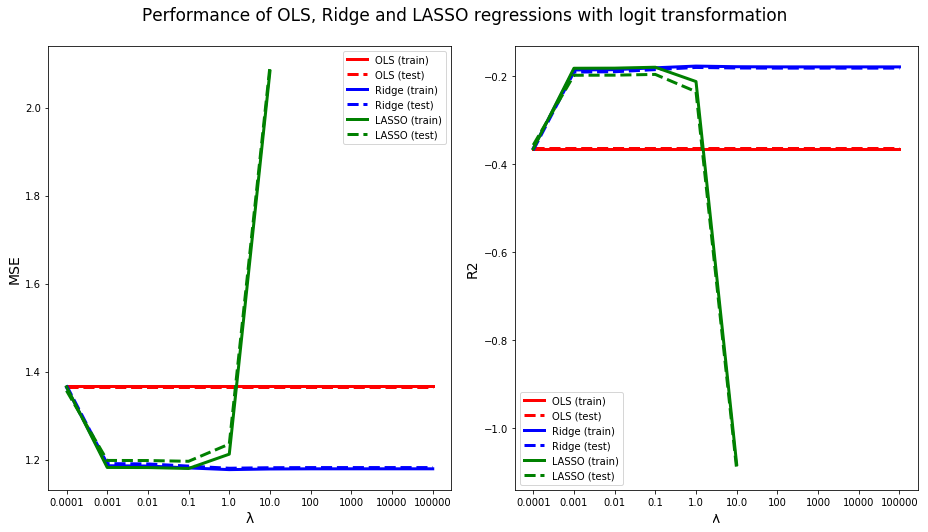

In [24]:
# Generate figure

# MSE
plt.figure(1, figsize = (13,7))
plt.subplot(1,2,1)
xlogr = np.log10(param_grid['ridge'])  # log x-axis
plt.plot(xlogr, (results["mse_train"]["ols"]*np.ones(len(xlogr))).T, 'r', label='OLS (train)', linewidth=3.0) 
plt.plot(xlogr, (results["mse_test"]["ols"]*np.ones(len(xlogr))).T, 'r--', label='OLS (test)',  linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["mse_train"]["ridge"]).T, 'b', label='Ridge (train)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["mse_test"]["ridge"]).T, 'b--', label='Ridge (test)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["mse_train"]["lasso"]).T, 'g', label='LASSO (train)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["mse_test"]["lasso"]).T, 'g--', label='LASSO (test)', linewidth=3.0) 
ax = plt.gca()
plt.xticks(np.asarray(xlogr))
ax.set_xticklabels(param_grid['ridge'])
plt.xlabel('λ', fontsize=14)
plt.ylabel('MSE', fontsize=14)
plt.legend()

# R-squared
plt.subplot(1,2,2)
plt.plot(xlogr, (results["r2_train"]["ols"]*np.ones(len(xlogr))).T, 'r', label='OLS (train)', linewidth=3.0) 
plt.plot(xlogr, (results["r2_test"]["ols"]*np.ones(len(xlogr))).T, 'r--', label='OLS (test)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["r2_train"]["ridge"]).T, 'b', label='Ridge (train)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["r2_test"]["ridge"]).T, 'b--', label='Ridge (test)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["r2_train"]["lasso"]).T, 'g', label='LASSO (train)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["r2_test"]["lasso"]).T, 'g--', label='LASSO (test)', linewidth=3.0) 
ax = plt.gca()
plt.xticks(np.asarray(xlogr))
ax.set_xticklabels(param_grid['ridge'])
plt.xlabel('λ', fontsize=14)
plt.ylabel('R2', fontsize=14)
plt.legend()
plt.suptitle("Performance of OLS, Ridge and LASSO regressions with logit transformation", y=1.05, fontsize=17)
plt.savefig("results/figures/metric_regression_on_allData_with_Logit.png", bbox_inches = "tight")
plt.tight_layout()    
plt.show()

# Regression analysis without any transformation, cloud cover fractions \in [0,1]

In [25]:
y = logit_inv(y) #transforming the data back. 

results, z_pred_best, coeffs = model_comparison(
    models, param_grid, X, y, split_size=0.2
    )

Testing model: ols
Testing model: ridge
Testing model: lasso
0


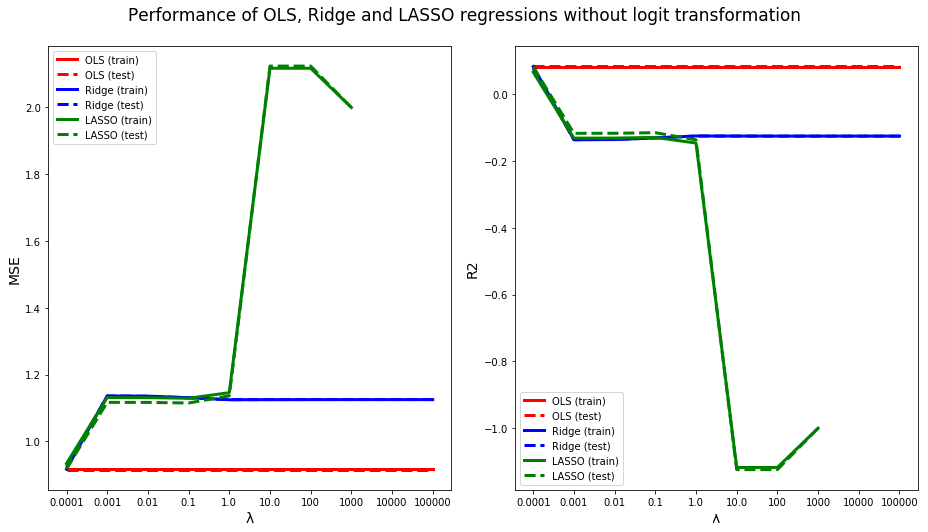

In [26]:
# Generate figure

# MSE
plt.figure(1, figsize = (13,7))
plt.subplot(1,2,1)
xlogr = np.log10(param_grid['ridge'])  # log x-axis
plt.plot(xlogr, (results["mse_train"]["ols"]*np.ones(len(xlogr))).T, 'r', label='OLS (train)', linewidth=3.0) 
plt.plot(xlogr, (results["mse_test"]["ols"]*np.ones(len(xlogr))).T, 'r--', label='OLS (test)',  linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["mse_train"]["ridge"]).T, 'b', label='Ridge (train)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["mse_test"]["ridge"]).T, 'b--', label='Ridge (test)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["mse_train"]["lasso"]).T, 'g', label='LASSO (train)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["mse_test"]["lasso"]).T, 'g--', label='LASSO (test)', linewidth=3.0) 
ax = plt.gca()
plt.xticks(np.asarray(xlogr))
ax.set_xticklabels(param_grid['ridge'])
plt.xlabel('λ', fontsize=14)
plt.ylabel('MSE', fontsize=14)
plt.legend()

# R-squared
plt.subplot(1,2,2)
plt.plot(xlogr, (results["r2_train"]["ols"]*np.ones(len(xlogr))).T, 'r', label='OLS (train)', linewidth=3.0) 
plt.plot(xlogr, (results["r2_test"]["ols"]*np.ones(len(xlogr))).T, 'r--', label='OLS (test)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["r2_train"]["ridge"]).T, 'b', label='Ridge (train)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["r2_test"]["ridge"]).T, 'b--', label='Ridge (test)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["r2_train"]["lasso"]).T, 'g', label='LASSO (train)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["r2_test"]["lasso"]).T, 'g--', label='LASSO (test)', linewidth=3.0) 
ax = plt.gca()
plt.xticks(np.asarray(xlogr))
ax.set_xticklabels(param_grid['ridge'])
plt.xlabel('λ', fontsize=14)
plt.ylabel('R2', fontsize=14)
plt.legend()
plt.suptitle("Performance of OLS, Ridge and LASSO regressions without logit transformation", y=1.05, fontsize=17)
plt.savefig("results/figures/metric_regression_on_allData_withoutLogit.png", bbox_inches = "tight")
plt.tight_layout()    
plt.show()

# Discuss effect of penalties on this with P

# Determining which feature is most important

## Results:

# Bias and variance discussion 

In [27]:
# Experimental setup
models = {
    "ols": algorithms.OLS, 
    "ridge": algorithms.Ridge, 
    "lasso": algorithms.Lasso, 
}

lmd = {
    'ols': [0],
    'lasso': [0.001],
    'ridge':[0.001]
    
}
nboots = 100

z_test, z_pred_test, bias, var, beta, mse_test, mse_train, ci_beta = resample(models, lmd, X, y, nboots, split_size = 0.2)

ci_beta.shape

(2, 4)

In [28]:
ci_beta.shape # Muligens ikke så mys vits med konfidenseintervall av disse dimensjoner. 

(2, 4)

In [29]:
bias

{'ridge': 0.0939780329781973,
 'lasso': 0.09508179161135429,
 'ols': 0.09397603454551548}

In [30]:
var # variance dominates because we don't have so mush data???

{'ridge': 3.663710933828034e-06,
 'lasso': 4.36150673898824e-06,
 'ols': 3.95325504867405e-06}

In [31]:
mse_test

{'ridge': 0.09398169668913112,
 'lasso': 0.09508615311809328,
 'ols': 0.09397998780056413}

In [32]:
bias["ols"] + var["ols"] 

0.09397998780056416

In [33]:
bias["ridge"] + var["ridge"] 

0.09398169668913113

In [34]:
bias["lasso"] + var["lasso"] 

0.09508615311809328

The bias and variance summes to the mse of the ols model.

In [35]:
#logit_inv(z_pred_best["lasso"])

# Compare with scikit learn without logit

In [36]:
y = logit_inv(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, split_size = 0.5)

In [37]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)
p = model.predict(X_test)
model.score(X_test, y_test) #returns the r2 score

0.30275527376373235

In [38]:
model.coef_

array([ 3.56139703e-03, -1.70643217e+01,  1.47373747e-06,  3.07685388e-03])

In [39]:
# relative humidity, specific humidity, pressure, temprature

# With logit transformation

In [40]:
y

array([0.73105258, 0.73105258, 0.73105858, ..., 0.51903464, 0.55011499,
       0.62107592])

In [41]:
y = logit(y)

In [42]:
y.min(), y.max()

(1.999511667349907e-12, 0.9999999999976487)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, split_size = 0.5)

model = LinearRegression()
model.fit(X_train, y_train)
p = model.predict(X_test)
model.score(X_test, y_test) #returns the r2 score

0.3014360405207115

In [44]:
X_b = logit_inv(p)
y_b = logit_inv(y_test)
n,p = np.shape(X_train)
print(n,p)
A_R2(X_b, y_b ,n, p)

65758 4


-1.3499676254593207

In [45]:
model.coef_

array([ 1.56867047e-02, -7.58563091e+01,  6.19729756e-06,  1.36371502e-02])

In [46]:
# relative humidity, specific humidity, pressure, temprature

# Linear regression using standard scaler

In [47]:
scaler = StandardScaler()
fit = scaler.fit(X)
p = scaler.transform(X)

In [48]:
#y = logit_inv(y)

#scaler = StandardScaler()
#fit = scaler.fit(y)
#yy = scaler.transform(y)

In [49]:
p

array([[ 1.26733946, -1.72037237,  0.53591332, -3.05580049],
       [ 1.20928871, -1.71051398,  0.53484103, -2.98743943],
       [ 1.19800871, -1.69197592,  0.52679884, -2.82467501],
       ...,
       [-2.15971843,  0.56205941, -1.33234106,  1.48194626],
       [-2.28641213,  0.43615061, -1.06512589,  1.50448288],
       [-2.40388925,  0.36735619, -0.75684194,  1.54354634]])

In [50]:
y

array([0.99996948, 0.99996948, 1.        , ..., 0.07617536, 0.20113531,
       0.49411747])

In [51]:
# Experimental setup
models = {
    "ols": algorithms.OLS,
    #"ols": LinearRegression,
    'ridge': algorithms.Ridge, 
    "lasso": algorithms.Lasso
}
param_grid = {
    'ols': [0],
    'ridge': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100, 10**3, 10**4, 10**5],  
    'lasso': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100, 10**3, 10**4, 10**5]
}

# Choosing the same splitsize as the notebook in order to compare. 
results, z_pred_best, coeffs = model_comparison(
    models, param_grid, p, y, split_size=0.2
    )

Testing model: ols
Testing model: ridge
Testing model: lasso
0


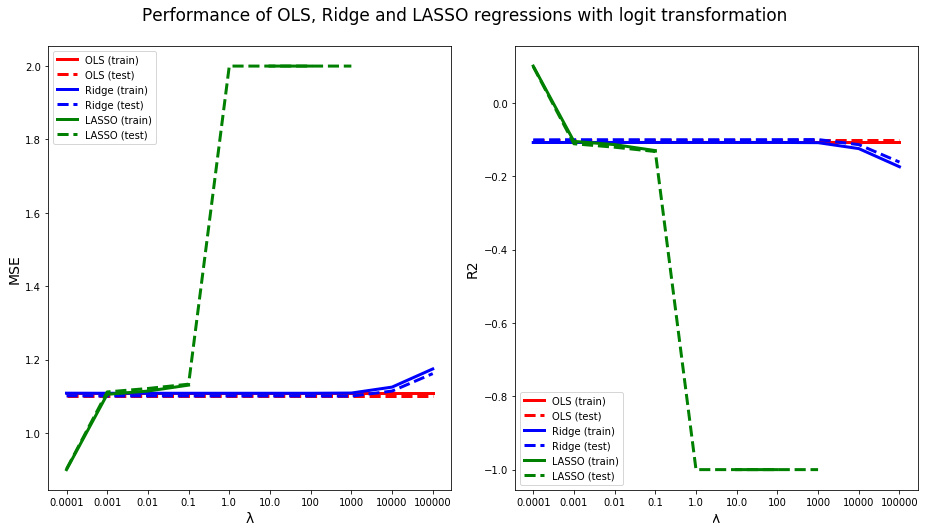

In [52]:
# Generate figure

# MSE
plt.figure(1, figsize = (13,7))
plt.subplot(1,2,1)
xlogr = np.log10(param_grid['ridge'])  # log x-axis
plt.plot(xlogr, (results["mse_train"]["ols"]*np.ones(len(xlogr))).T, 'r', label='OLS (train)', linewidth=3.0) 
plt.plot(xlogr, (results["mse_test"]["ols"]*np.ones(len(xlogr))).T, 'r--', label='OLS (test)',  linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["mse_train"]["ridge"]).T, 'b', label='Ridge (train)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["mse_test"]["ridge"]).T, 'b--', label='Ridge (test)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["mse_train"]["lasso"]).T, 'g', label='LASSO (train)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["mse_test"]["lasso"]).T, 'g--', label='LASSO (test)', linewidth=3.0) 
ax = plt.gca()
plt.xticks(np.asarray(xlogr))
ax.set_xticklabels(param_grid['ridge'])
plt.xlabel('λ', fontsize=14)
plt.ylabel('MSE', fontsize=14)
plt.legend()

# R-squared
plt.subplot(1,2,2)
plt.plot(xlogr, (results["r2_train"]["ols"]*np.ones(len(xlogr))).T, 'r', label='OLS (train)', linewidth=3.0) 
plt.plot(xlogr, (results["r2_test"]["ols"]*np.ones(len(xlogr))).T, 'r--', label='OLS (test)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["r2_train"]["ridge"]).T, 'b', label='Ridge (train)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["r2_test"]["ridge"]).T, 'b--', label='Ridge (test)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["r2_train"]["lasso"]).T, 'g', label='LASSO (train)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["r2_test"]["lasso"]).T, 'g--', label='LASSO (test)', linewidth=3.0) 
ax = plt.gca()
plt.xticks(np.asarray(xlogr))
ax.set_xticklabels(param_grid['ridge'])
plt.xlabel('λ', fontsize=14)
plt.ylabel('R2', fontsize=14)
plt.legend()
plt.suptitle("Performance of OLS, Ridge and LASSO regressions with logit transformation", y=1.05, fontsize=17)
plt.savefig("results/figures/metric_regression_on_allData_with_Logit.png", bbox_inches = "tight")
plt.tight_layout()    
plt.show()

# I removed OLS and Ridge from the plot because they have horrible results, and makes it difficult to read the lasso result, which is the best for linear regression !!


# 1. Skriv om koden så den inneholder labels at r2 nå er adjusted r2 og at mse er nå normalized root mean square error !! 